In [1]:
import pandas as pd
import numpy as np
import nltk
import codecs
import re
import matplotlib.pyplot as plt

from   nltk.stem.isri                  import ISRIStemmer
from   sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from   sklearn.model_selection         import train_test_split
from   sklearn.naive_bayes             import ComplementNB

from   sklearn.metrics                 import classification_report

import time
st  = ISRIStemmer()
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("data/DtaSetsGhadeer.xlsx")
data.head()

,text,label
0,تستاهل فنانة العرب قلب أخضر من يمثل الأغنية ال...,1
1,ومن غير فنانة العرب يستاهل التكريم بنت زايد تس...,1
2,تستاهل فنانة العرب التكريم,1
3,تستاهل ام فاهد كل خير,1
4,شكراً هيئة الترفيه على هذا التكريم المُستحق لم...,1


### Data pre-processing

In [3]:
data = data[~(data.label==2)]
data = data.dropna()

In [4]:
def clean(text):
    text = str(text)
    text = normalize(text)
    stopWords 			= codecs.open("data/stopWords.csv","r",encoding='utf-8').read().split('\n')#load stopwords list
    words 				= text.split(' ')#split input text to words tokines
    filtered_words 		= []
    for word in words:#loop on words
        if word not in stopWords:#check if word is stopword or not
            filtered_words.append(st.stem(word))#append to filtered list if not stopword
    filtered_sentence 	= ' '.join(filtered_words)#concatenate all filtered words to new sentences
    return filtered_sentence

In [5]:
def normalize(text):
    text = str(text)
    text = re.sub(r"[إأٱآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ئ", "ء", text)
    text = re.sub(r'[^ا-ي ]', "", text)
    text = re.sub(' +', ' ',text)
    text = re.sub('ـ',"",text)
    return text

### Train test split

In [6]:
tfidf = TfidfVectorizer()
def preprocess(x,y):
    x     = tfidf.fit_transform(x)#.toarray()
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state = 0)
    return x_train,x_test,y_train,y_test


### Modeling

In [7]:
def compare(x_train,x_test,y_train,y_test):
    global clf
    global clfs
    clfs = [ComplementNB()]
    
    model_names    = []
    accuracies     = []
    crs            = []
    times          = []
    for clf in clfs:
        model_name = str(clf).split('(')[0]
        print(model_name)
        if model_name=="ComplementNB":
            x_train = x_train.toarray()
            x_test  = x_test.toarray()

        t          = time.time()
        clf.fit(x_train,y_train)
        accuracy   = round(clf.score(x_test,y_test)*100,2)
        cr         = classification_report(y_test,clf.predict(x_test),output_dict=True)
        t_time     = round(time.time()-t,2)
        accuracies.append(accuracy)
        times.append(t_time)
        model_names.append(model_name)
        crs.append(list(cr['0'].values())+list(cr['1'].values()))
    crs = np.array(crs)
    res = pd.DataFrame({"model_name":model_names,"accuracy":accuracies,"precision_0":crs[:,0],
                        "precision_0":crs[:,0],"recall_0":crs[:,1],"f1-score_0":crs[:,2],
                        "support_0":crs[:,3],"precision_1":crs[:,4],"recall_1":crs[:,5],
                        "f1-score_1":crs[:,6],"support_1":crs[:,7],"time":times
                       })
    res = res.sort_values(by="accuracy",ascending=False)
    return res   

#### Evaluation without any data preprocessing

In [8]:
x_train,x_test,y_train,y_test = preprocess(data.text.astype("str"),data.label)
df_without = compare(x_train,x_test,y_train,y_test)

ComplementNB


In [9]:
text = "مثل الشياطين ما يصير الاحتفال إلا ليلة الجمعه حسبي الله على من قرر ذلك                                أكثروا من الصلاة على النبي ﷺ"
text = tfidf.transform([text]).toarray()
clf = clfs[0]
print(clf)
clf.predict(text)

ComplementNB()


array([0], dtype=int64)

In [10]:
print(x_train.shape)
print(x_test.shape)

(48, 563)
(16, 563)


#### Evaluation with stemming & normalization & stopwords

In [11]:
x = data['text'].apply(clean)
y = data.label
x_train,x_test,y_train,y_test = preprocess(x,y)
df_all = compare(x_train,x_test,y_train,y_test)

ComplementNB


In [12]:
models_res = [
    {"data":df_all,"title":"Result after applying all preprocessing Methods"},
]

In [13]:
models_res[0]['data']

,model_name,accuracy,precision_0,recall_0,f1-score_0,support_0,precision_1,recall_1,f1-score_1,support_1,time
0,ComplementNB,50.0,1.0,0.384615,0.555556,13.0,0.272727,1.0,0.428571,3.0,0.01


In [14]:
data['label'].value_counts()

0    44
1    20
Name: label, dtype: int64

,Tweets
Positive,20
Negative,44


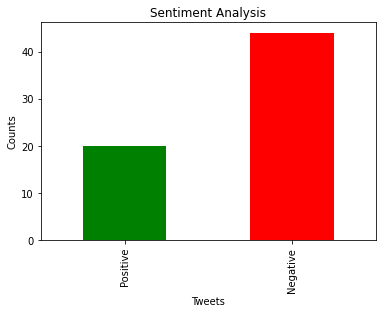

In [15]:
plotdata = pd.DataFrame({
    "Tweets": [20, 44]}, 
    index=["Positive", "Negative"])

plotdata['Tweets'].plot(kind="bar",color=['green','red'])
plt.xlabel("Tweets")
plt.ylabel("Counts")
plt.title("Sentiment Analysis")
plotdata.head()

,Tweets
Positive,20
Negative,44


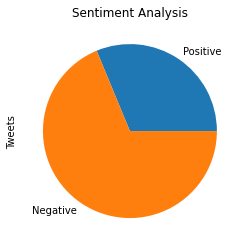

In [16]:
plotdata = pd.DataFrame({
    "Tweets": [20, 44]}, 
    index=["Positive", "Negative"])

plotdata['Tweets'].plot(kind="pie")
plt.title("Sentiment Analysis")
plotdata.head()